<h1><center>Assignment 12</h1></center>
<h2><center>Benedek Dankó</h2></center>


Data source: https://www.nature.com/articles/s41586-018-0352-3#Sec7

In [ ]:
# import required packages:

%tensorflow_version 2.x
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, scale
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score

from google.colab import drive

#### 1. Load & prepare data

In [ ]:
# read data:
data = pd.read_csv('../data/Donihue 2018-01-00672 Hurricanes Data.csv', na_values=" ")

In [ ]:
data.head()

,ID,Hurricane,Origin,Sex,SVL,Femur,Tibia,Metatarsal,LongestToe,Humerus,Radius,Metacarpal,LongestFinger,FingerCount,ToeCount,FingerArea1,FingerArea2,FingerArea3,ToeArea1,ToeArea2,ToeArea3,MeanFingerArea,MeanToeArea,SumFingers,SumToes,MaxFingerForce
0,537,After,Pine Cay,Male,48.69,10.39,11.87,7.52,7.43,8.66,7.99,2.22,3.19,10.0,12.0,1.321,1.338,1.339,2.529,2.402,2.369,1.332667,2.433333,2.663,4.791,0.116
1,539,After,Pine Cay,Female,40.31,8.66,9.79,6.18,6.20,8.01,6.51,2.38,3.55,10.0,13.0,0.962,0.950,0.972,1.498,1.525,1.530,0.961333,1.517667,2.595,3.678,0.048
2,540,After,Pine Cay,Male,58.30,12.87,14.76,9.45,9.58,11.72,9.54,3.54,5.09,14.0,15.0,2.507,2.702,2.685,4.157,4.140,3.996,2.631333,4.097667,7.347,4.682,0.424
3,541,After,Pine Cay,Female,43.15,8.55,10.29,6.60,6.26,7.43,6.60,2.79,3.55,11.0,12.0,1.172,1.175,1.186,1.898,1.871,1.867,1.177667,1.878667,2.786,5.378,0.171
4,542,After,Pine Cay,Female,45.51,10.26,11.02,6.89,7.02,7.71,7.25,2.52,3.37,11.0,13.0,1.376,1.357,1.420,2.627,2.435,2.529,1.384333,2.530333,3.575,6.646,0.014


In [ ]:
def my_encoder(array):
    '''
    Encoding of an array to numeric format.
    '''
    unique_items = list(set(array))
    n = len(unique_items)
    encoded_array = []
    for i in array:
        encoded_array.append(unique_items.index(i))
    return encoded_array

In [ ]:
cat_cols = ['Hurricane', 'Origin', 'Sex']

In [ ]:
# convert categorical columns to numeric:
for col in cat_cols:
    data[col] = my_encoder(data[col])

In [ ]:
data.drop(['ID', 'SumFingers', 'SumToes', 'MaxFingerForce'], axis=1, inplace=True) # drop ID column, and 3 more columns, where only after hurricane measurements exist
data = data.dropna(thresh=data.shape[1]-5).reset_index().drop('index', axis=1) # drop rows with too many Nans (actually, there is only one row...)
data.head() # only numeric values

,Hurricane,Origin,Sex,SVL,Femur,Tibia,Metatarsal,LongestToe,Humerus,Radius,Metacarpal,LongestFinger,FingerCount,ToeCount,FingerArea1,FingerArea2,FingerArea3,ToeArea1,ToeArea2,ToeArea3,MeanFingerArea,MeanToeArea
0,1,1,1,48.69,10.39,11.87,7.52,7.43,8.66,7.99,2.22,3.19,10.0,12.0,1.321,1.338,1.339,2.529,2.402,2.369,1.332667,2.433333
1,1,1,0,40.31,8.66,9.79,6.18,6.20,8.01,6.51,2.38,3.55,10.0,13.0,0.962,0.950,0.972,1.498,1.525,1.530,0.961333,1.517667
2,1,1,1,58.30,12.87,14.76,9.45,9.58,11.72,9.54,3.54,5.09,14.0,15.0,2.507,2.702,2.685,4.157,4.140,3.996,2.631333,4.097667
3,1,1,0,43.15,8.55,10.29,6.60,6.26,7.43,6.60,2.79,3.55,11.0,12.0,1.172,1.175,1.186,1.898,1.871,1.867,1.177667,1.878667
4,1,1,0,45.51,10.26,11.02,6.89,7.02,7.71,7.25,2.52,3.37,11.0,13.0,1.376,1.357,1.420,2.627,2.435,2.529,1.384333,2.530333


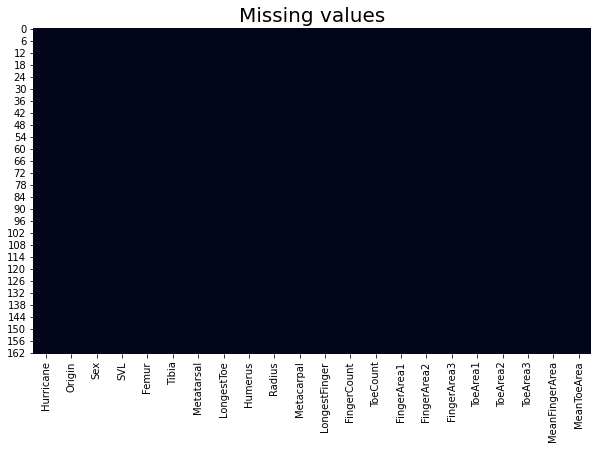

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False)
plt.title('Missing values', fontsize=20)
plt.show()

#### 2. T-SNE

In [ ]:
# select columns (no categorical features):
data_numeric = data.drop(['Sex', 'Hurricane', 'Origin'], axis=1)

In [ ]:
# scale the data:
data_transformed = MinMaxScaler().fit_transform(data_numeric)

In [ ]:
tsne = TSNE(random_state = 123)

In [ ]:
%%time
# measuring time
# fit model to the the normalized data:
embedded = tsne.fit_transform(data_transformed)

CPU times: user 1.72 s, sys: 64.5 ms, total: 1.78 s
Wall time: 921 ms


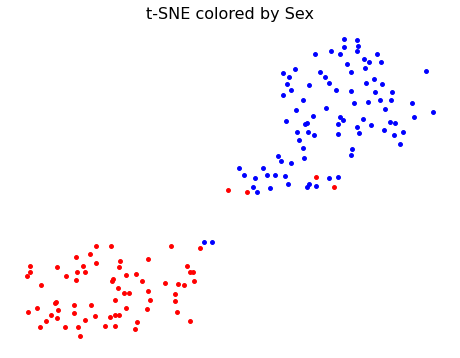

In [ ]:
# plot the data:
fig, ax = plt.subplots(figsize=(8, 6))
ax.axes.set_title('t-SNE colored by Sex',fontsize=16)
for i, j in enumerate(embedded[:,0]):
    if data.Sex.to_list()[i] == 1:
        plt.scatter(embedded[:,0][i] , embedded[:,1][i], c='blue', s=15, marker='o') # male
    else:
        plt.scatter(embedded[:,0][i] , embedded[:,1][i], c='red', s=15, marker='o') # female
plt.axis('off')
plt.show()

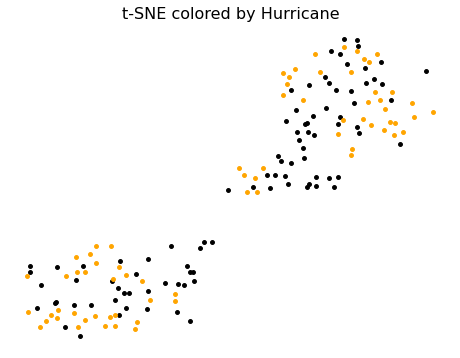

In [ ]:
# plot the data:
fig, ax = plt.subplots(figsize=(8, 6))
ax.axes.set_title('t-SNE colored by Hurricane',fontsize=16)
for i, j in enumerate(embedded[:,0]):
    if data.Hurricane.to_list()[i] == 1:
        plt.scatter(embedded[:,0][i] , embedded[:,1][i], c='black', s=15, marker='o') # after
    else:
        plt.scatter(embedded[:,0][i] , embedded[:,1][i], c='orange', s=15, marker='o') # before
plt.axis('off')
plt.show()

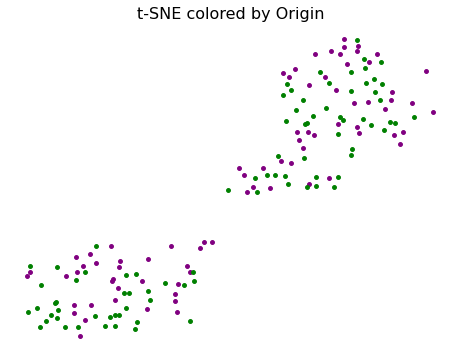

In [ ]:
# plot the data:
fig, ax = plt.subplots(figsize=(8, 6))
ax.axes.set_title('t-SNE colored by Origin',fontsize=16)
for i, j in enumerate(embedded[:,0]):
    if data.Origin.to_list()[i] == 1:
        plt.scatter(embedded[:,0][i] , embedded[:,1][i], c='purple', s=15, marker='o') # Pine Cay
    else:
        plt.scatter(embedded[:,0][i] , embedded[:,1][i], c='green', s=15, marker='o') # Water Cay
plt.axis('off')
plt.show()

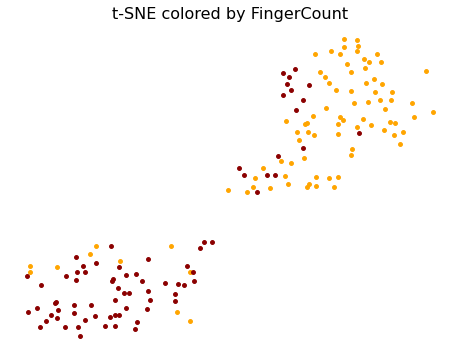

In [ ]:
# plot the data:
fig, ax = plt.subplots(figsize=(8, 6))
ax.axes.set_title('t-SNE colored by FingerCount',fontsize=16)
for i, j in enumerate(embedded[:,0]):
    if data.FingerCount.to_list()[i] < np.mean(data.FingerCount):
        plt.scatter(embedded[:,0][i] , embedded[:,1][i], c='darkred', s=15, marker='o') # lower finger count (lower than avg.)
    else:
        plt.scatter(embedded[:,0][i] , embedded[:,1][i], c='orange', s=15, marker='o') # higher finger count (>= avg.)
plt.axis('off')
plt.show()

The best separation is based on the *Sex* variable. <br>
The other separations are not so nice.

We got basically two main clusters, which seems to be based on the sex of the lizzards.

#### 3. Linear model + fine-tune

In [ ]:
# create x matrix, y array:
y = data.Hurricane
x = data.drop('Hurricane', axis=1).to_numpy()

GridSearch cross-validation, with 5-fold cross-validation, using Logisitc Regression with L2 regularization:

In [ ]:
params = {'C': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1, 2, 5, 10]}

# default cv: 5-fold cross-validation
gs = GridSearchCV(estimator=LogisticRegression(random_state=1001, penalty='l2', max_iter=1000), 
                      param_grid=params, 
                      verbose=1,  # verbose: the higher, the more messages
                      scoring='accuracy', 
                      return_train_score=True)

gs.fit(x, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.4s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=1001, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1, 2, 5, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=1)

In [ ]:
print(f'Best C parameter found: {gs.best_params_["C"]}')

Best C parameter found: 5


In [ ]:
lr = LogisticRegression(random_state=1001, penalty='l2', max_iter=500, C=gs.best_params_['C']).fit(x, y)

In [ ]:
probs = lr.predict_proba(x)
preds = probs[:,1] # probability values 
fpr, tpr, threshold = metrics.roc_curve(y, preds)
roc_auc = metrics.auc(fpr, tpr)

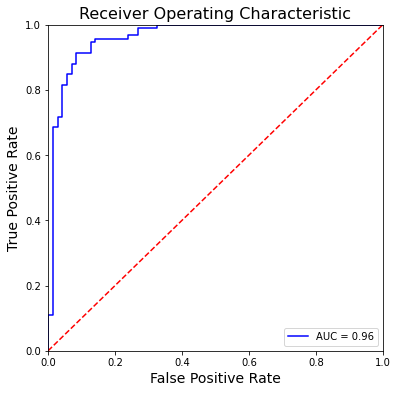

In [ ]:
# Plot the data:
plt.figure(figsize=(6,6))
plt.title('Receiver Operating Characteristic', fontsize=16)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=14)
plt.show()

#### 4. SVM + fine-tune

Firstly, let's scale the data (the x variables):

In [ ]:
x_scaled = scale(data.drop('Hurricane', axis=1))
y_scaled = data.Hurricane.to_numpy()

Run a KFold cross-validation with linear kernel:

In [ ]:
params = {'C': [0.1, 1, 10, 100, 500], 
          'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
          'kernel': ['rbf', 'poly']}

# default cv: 5-fold cross-validation
gs = GridSearchCV(estimator=SVC(), 
                      param_grid=params, 
                      verbose=1,  # verbose: the higher, the more messages
                      scoring='accuracy', 
                      return_train_score=True)

gs.fit(x_scaled, y_scaled)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.9s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 500],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=1)

In [ ]:
print(f'Best parameter settings: {gs.best_params_}')

Best parameter settings: {'C': 500, 'gamma': 0.001, 'kernel': 'rbf'}


Best model found:

In [ ]:
svm = SVC(C=gs.best_params_['C'], 
          gamma=gs.best_params_['gamma'], 
          kernel=gs.best_params_['kernel'], 
          random_state=11).fit(x, y)

In [ ]:
probs = lr.predict_proba(x)
preds = probs[:,1] # probability values 
fpr, tpr, threshold = metrics.roc_curve(y, preds)
roc_auc = metrics.auc(fpr, tpr)

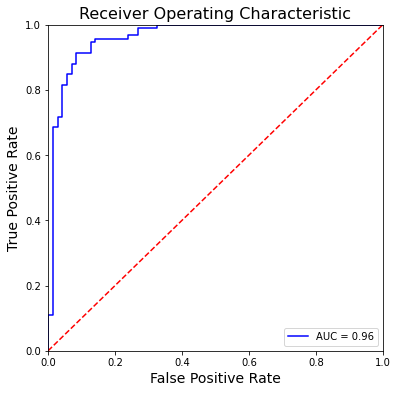

In [ ]:
# Plot the data:
plt.figure(figsize=(6,6))
plt.title('Receiver Operating Characteristic', fontsize=16)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=14)
plt.show()

#### 5. RF + feature importances

In [ ]:
params = {'max_depth' : [4, 6, 8, 10, 15, 20, 30],
          'n_estimators' : [50, 100, 200, 300]}

In [ ]:
# default cv: 5-fold cross-validation
gs = GridSearchCV(estimator=RandomForestClassifier(), 
                  param_grid=params, 
                  verbose=1,  # verbose: the higher, the more messages
                  scoring='accuracy', 
                  return_train_score=True,
                  n_jobs=-1)

gs.fit(x, y)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:   31.2s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [ ]:
print(f'Best parameter settings: {gs.best_params_}')

Best parameter settings: {'max_depth': 8, 'n_estimators': 100}


Random Forest Classifier with the best parameter settings:

In [ ]:
rf = RandomForestClassifier(random_state=11, 
                            max_depth=gs.best_params_['max_depth'], 
                            n_estimators=gs.best_params_['n_estimators']).fit(x, y)

In [ ]:
probs = lr.predict_proba(x)
preds = probs[:,1] # probability values 
fpr, tpr, threshold = metrics.roc_curve(y, preds)
roc_auc = metrics.auc(fpr, tpr)

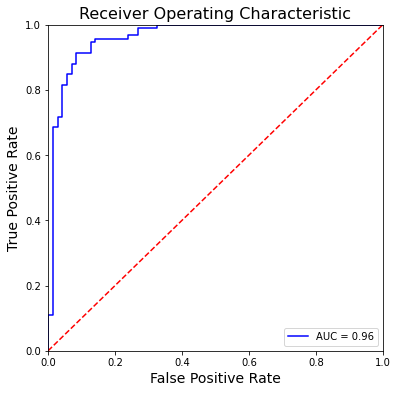

In [ ]:
# Plot the data:
plt.figure(figsize=(6,6))
plt.title('Receiver Operating Characteristic', fontsize=16)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=14)
plt.show()

In [ ]:
# store the 5 most important features:
top_features = [x for _,x in sorted(zip(rf.feature_importances_, data.columns), reverse=True)][:5]

In [ ]:
# create dataframe:
df = pd.DataFrame({'Feature': top_features, 
                     'Importance': sorted(rf.feature_importances_, reverse=True)[:5]})

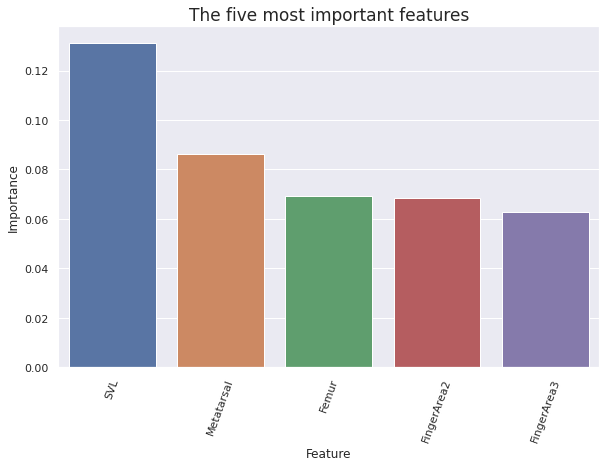

In [ ]:
# plot the data:
sns.set(rc={'figure.figsize':(9.7,6.27)})
ax = sns.barplot(x='Feature', y='Importance', data=df)
plt.title('The five most important features', fontsize=17)
plt.xticks(rotation=70)
plt.show()

Based on this, the most important feature is the *SVL* variable.